In [2]:
import numpy as np
import pandas as pd

import string
import importlib

import russia_df_utils
importlib.reload(russia_df_utils)
from russia_df_utils import get_uncategorized_df_rows

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim import corpora, models, similarities, matutils
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
import matplotlib as mpl

import seaborn as sns
sns.set()

%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.tokenizer = TweetTokenizer(preserve_case=False)
    def __call__(self, doc):
        tokens = self.tokenizer.tokenize(doc)
        tokens = [word for word in tokens if word.isalpha()]
        return [self.wnl.lemmatize(t) for t in tokens]


In [4]:
clustering_text = get_uncategorized_df_rows(drop_retweets=True)['processed_text']

In [5]:
stop_words = set(stopwords.words('english'))
#stop_words.remove('not')
#stop_words.remove('all')
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=10, max_df=0.8)
vectorized_tweets = tfidf.fit_transform(clustering_text.values)

#pd.DataFrame(vectorized_tweets.todense(), 
#             columns=tfidf.get_feature_names()
#            ).head()

tfidf_corpus = matutils.Sparse2Corpus(vectorized_tweets.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)




2018-03-07 04:30:11,279 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-07 04:30:11,355 : INFO : adding document #10000 to Dictionary(0 unique tokens: [])
2018-03-07 04:30:11,431 : INFO : adding document #20000 to Dictionary(0 unique tokens: [])
2018-03-07 04:30:11,508 : INFO : adding document #30000 to Dictionary(0 unique tokens: [])
2018-03-07 04:30:11,585 : INFO : adding document #40000 to Dictionary(0 unique tokens: [])
2018-03-07 04:30:11,662 : INFO : adding document #50000 to Dictionary(0 unique tokens: [])
2018-03-07 04:30:11,706 : INFO : built Dictionary(6586 unique tokens: ['reacts', 'dirt', 'drink', 'extra politics', 'al qaeda']...) from 51867 documents (total 120224 corpus positions)


In [6]:
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=10, power_iters=10)


2018-03-07 04:30:11,711 : INFO : using serial LSI version on this node
2018-03-07 04:30:11,712 : INFO : updating model with new documents
2018-03-07 04:30:11,774 : INFO : preparing a new chunk of documents
2018-03-07 04:30:11,859 : INFO : using 100 extra samples and 10 power iterations
2018-03-07 04:30:11,861 : INFO : 1st phase: constructing (6586, 110) action matrix
2018-03-07 04:30:11,992 : INFO : orthonormalizing (6586, 110) action matrix
2018-03-07 04:30:12,841 : INFO : 2nd phase: running dense svd on (110, 20000) matrix
2018-03-07 04:30:13,198 : INFO : computing the final decomposition
2018-03-07 04:30:13,201 : INFO : keeping 10 factors (discarding 79.665% of energy spectrum)
2018-03-07 04:30:13,206 : INFO : processed documents up to #20000
2018-03-07 04:30:13,212 : INFO : topic #0(12.269): 0.656*"realdonaldtrump" + 0.461*"hillaryclinton" + 0.352*"politics" + 0.115*"obama" + 0.109*"news" + 0.092*"campaign" + 0.089*"says" + 0.074*"hillaryclinton realdonaldtrump" + 0.074*"people" + 

In [7]:
lsi.print_topics()

2018-03-07 04:30:19,534 : INFO : topic #0(19.843): 0.673*"realdonaldtrump" + 0.455*"hillaryclinton" + 0.345*"politics" + 0.111*"news" + 0.106*"obama" + 0.091*"campaign" + 0.084*"says" + 0.072*"hillaryclinton realdonaldtrump" + 0.068*"realdonaldtrump hillaryclinton" + 0.068*"people"
2018-03-07 04:30:19,535 : INFO : topic #1(14.168): 0.761*"hillaryclinton" + -0.581*"realdonaldtrump" + 0.072*"bill" + 0.064*"bill hillaryclinton" + 0.056*"trumpforpresident" + 0.051*"hillaryclinton campaign" + 0.046*"hillaryforprison2016" + 0.043*"fbi" + 0.042*"obama" + 0.040*"like"
2018-03-07 04:30:19,536 : INFO : topic #2(13.467): 0.321*"people" + 0.251*"like" + 0.249*"love" + -0.246*"politics" + -0.221*"hillaryclinton" + 0.194*"trumpforpresident" + 0.159*"one" + 0.156*"obama" + 0.154*"islamkills" + 0.153*"know"
2018-03-07 04:30:19,537 : INFO : topic #3(12.739): -0.688*"trumpforpresident" + -0.397*"hillaryforprison2016" + -0.266*"hillaryforprison2016 trumpforpresident" + 0.194*"obama" + 0.190*"politics" + 

[(0,
  '0.673*"realdonaldtrump" + 0.455*"hillaryclinton" + 0.345*"politics" + 0.111*"news" + 0.106*"obama" + 0.091*"campaign" + 0.084*"says" + 0.072*"hillaryclinton realdonaldtrump" + 0.068*"realdonaldtrump hillaryclinton" + 0.068*"people"'),
 (1,
  '0.761*"hillaryclinton" + -0.581*"realdonaldtrump" + 0.072*"bill" + 0.064*"bill hillaryclinton" + 0.056*"trumpforpresident" + 0.051*"hillaryclinton campaign" + 0.046*"hillaryforprison2016" + 0.043*"fbi" + 0.042*"obama" + 0.040*"like"'),
 (2,
  '0.321*"people" + 0.251*"like" + 0.249*"love" + -0.246*"politics" + -0.221*"hillaryclinton" + 0.194*"trumpforpresident" + 0.159*"one" + 0.156*"obama" + 0.154*"islamkills" + 0.153*"know"'),
 (3,
  '-0.688*"trumpforpresident" + -0.397*"hillaryforprison2016" + -0.266*"hillaryforprison2016 trumpforpresident" + 0.194*"obama" + 0.190*"politics" + -0.113*"maga" + -0.110*"realdonaldtrump" + 0.110*"people" + -0.107*"trumppence16" + -0.107*"vote"'),
 (4,
  '0.553*"obama" + 0.378*"politics" + -0.307*"love" + -0.

127.27874144922478

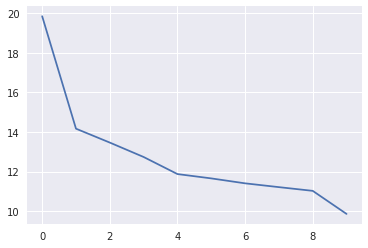

In [8]:
plt.plot(lsi.projection.s)
np.sum(lsi.projection.s)

In [9]:
lsi_5 = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=5, power_iters=10)

2018-03-07 04:30:41,458 : INFO : using serial LSI version on this node
2018-03-07 04:30:41,459 : INFO : updating model with new documents
2018-03-07 04:30:41,525 : INFO : preparing a new chunk of documents
2018-03-07 04:30:41,610 : INFO : using 100 extra samples and 10 power iterations
2018-03-07 04:30:41,612 : INFO : 1st phase: constructing (6586, 105) action matrix
2018-03-07 04:30:41,726 : INFO : orthonormalizing (6586, 105) action matrix
2018-03-07 04:30:42,391 : INFO : 2nd phase: running dense svd on (105, 20000) matrix
2018-03-07 04:30:42,720 : INFO : computing the final decomposition
2018-03-07 04:30:42,723 : INFO : keeping 5 factors (discarding 86.987% of energy spectrum)
2018-03-07 04:30:42,728 : INFO : processed documents up to #20000
2018-03-07 04:30:42,730 : INFO : topic #0(12.269): 0.656*"realdonaldtrump" + 0.461*"hillaryclinton" + 0.352*"politics" + 0.115*"obama" + 0.109*"news" + 0.092*"campaign" + 0.089*"says" + 0.074*"hillaryclinton realdonaldtrump" + 0.074*"people" + 0

In [23]:
lsi_5.print_topics()

2018-03-06 04:03:14,053 : INFO : topic #0(19.857): 0.663*"realdonaldtrump" + 0.451*"hillaryclinton" + 0.342*"politics" + 0.110*"news" + 0.109*"not" + 0.107*"obama" + 0.090*"campaign" + 0.083*"says" + 0.071*"hillaryclinton realdonaldtrump" + 0.071*"people"
2018-03-06 04:03:14,057 : INFO : topic #1(14.227): 0.501*"not" + -0.433*"realdonaldtrump" + 0.257*"hillaryclinton" + 0.218*"all" + 0.206*"people" + -0.192*"politics" + 0.160*"like" + 0.125*"love" + 0.122*"islamkills" + 0.113*"know"
2018-03-06 04:03:14,060 : INFO : topic #2(14.007): -0.750*"hillaryclinton" + 0.410*"realdonaldtrump" + 0.290*"not" + 0.119*"people" + 0.112*"all" + -0.103*"politics" + 0.082*"love" + 0.075*"like" + 0.069*"islamkills" + -0.067*"bill"
2018-03-06 04:03:14,061 : INFO : topic #3(12.716): -0.665*"trumpforpresident" + -0.379*"hillaryforprison2016" + 0.345*"not" + -0.255*"hillaryforprison2016 trumpforpresident" + 0.244*"politics" + -0.114*"maga" + -0.111*"vote" + 0.109*"obama" + -0.106*"trumppence16" + -0.094*"trum

[(0,
  '0.663*"realdonaldtrump" + 0.451*"hillaryclinton" + 0.342*"politics" + 0.110*"news" + 0.109*"not" + 0.107*"obama" + 0.090*"campaign" + 0.083*"says" + 0.071*"hillaryclinton realdonaldtrump" + 0.071*"people"'),
 (1,
  '0.501*"not" + -0.433*"realdonaldtrump" + 0.257*"hillaryclinton" + 0.218*"all" + 0.206*"people" + -0.192*"politics" + 0.160*"like" + 0.125*"love" + 0.122*"islamkills" + 0.113*"know"'),
 (2,
  '-0.750*"hillaryclinton" + 0.410*"realdonaldtrump" + 0.290*"not" + 0.119*"people" + 0.112*"all" + -0.103*"politics" + 0.082*"love" + 0.075*"like" + 0.069*"islamkills" + -0.067*"bill"'),
 (3,
  '-0.665*"trumpforpresident" + -0.379*"hillaryforprison2016" + 0.345*"not" + -0.255*"hillaryforprison2016 trumpforpresident" + 0.244*"politics" + -0.114*"maga" + -0.111*"vote" + 0.109*"obama" + -0.106*"trumppence16" + -0.094*"trump2k16"'),
 (4,
  '-0.661*"love" + 0.559*"not" + 0.210*"trumpforpresident" + -0.150*"people" + -0.142*"all" + -0.141*"like" + 0.124*"hillaryforprison2016" + -0.093*

In [34]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi_5[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]
ng_lsi = matutils.corpus2dense(lsi_corpus, num_terms=300).transpose()


NameError: name 'lsi_5' is not defined

In [25]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(ng_lsi)


In [26]:
pd.value_counts(pd.Series(clusters))

1    35373
2     6953
4     6022
0     2488
3     1031
dtype: int64

In [27]:
lower = 0
upper = 25
zipped_clusters = list(zip(clusters[lower:upper], clustering_text.values[lower:upper]))
for cluster in zipped_clusters:
    print(cluster)

(1, '#IslamKills Are you trying to say that there were no terrorist attacks in Europe before refugees were let in?')
(4, '@HillaryClinton: @realDonaldTrump should’ve apologized more, attacked less ')
(1, '@ModicaGiunta me, too!')
(1, 'One of the ways to remind that #BlackLivesMatter #BlackPressDay')
(1, 'Dave Chappelle: "blacklivesmatter" is the worst slogan I\'ve ever heard! How about "enough is enough"? VotingTrump! ')
(1, '#My2017BiggestHope to reach this level of pettiness ')
(1, 'The war is here! \nThis gentleman made more sense in 30 sec than #Obama for all time of his presidency.. ')
(2, "Obama on @realDonaldTrump winning: 'Anything's possible'  #politics")
(1, 'it’s impossible! #TexasJihad')
(1, 'Bewaffnete attackieren Bus mit koptischen Christen #Islamisten #ISIS \n')
(1, 'The bright example of our failing education ')
(1, '@sendavidperdue How are they gonna protect us if they just let a bunch of terrorist walk the cities of our city? #StopIslam #IslamKills')
(1, 'FC Barcelona

In [28]:
agglo_model = AgglomerativeClustering(affinity='cosine', linkage='average')
a_clusters = agglo_model.fit_predict(ng_lsi)

a_clusters[0:5]

ValueError: The condensed distance matrix must contain only finite values.